<a href="https://colab.research.google.com/github/Varun-Mulchandani/591-RTDL/blob/main/proj/ResNet_Solving_90CIFAR10_Prune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms 

In [ ]:
from PIL import Image

import torch
import torchvision

from torchvision.transforms import Compose, PILToTensor, ToPILImage

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

torch.manual_seed(1)
torch.cuda.manual_seed(1)
net = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
training_required = False


if training_required:
  for epoch in range(10):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

  print('Finished Training')
else:
  net = torch.load('/content/drive/MyDrive/res.pt', map_location = torch.device('cpu'))

In [ ]:
# torch.save(net, '/content/drive/MyDrive/res.pt')

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)

# print images
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

GroundTruth:  dog   horse truck ship 


In [ ]:
# # print(images)
# print(images.size())

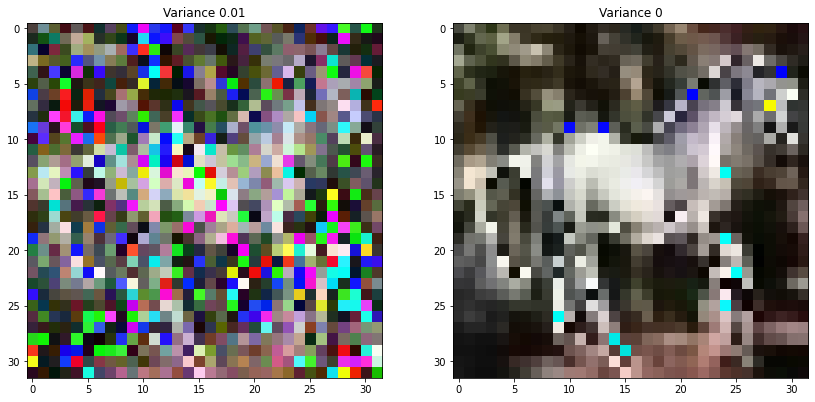

In [ ]:
from PIL import Image

import torch
import torchvision

from torchvision.transforms import Compose, PILToTensor, ToPILImage

img = images[1]

img = img + (0.01**0.5)*torch.randn(3, 32, 32)

trans = transforms.ToPILImage()
img1 = trans(img)
img2 = trans(images[1])
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.title("Variance 0.01")
plt.imshow(img1)
plt.subplot(122)
plt.title("Variance 0")
plt.imshow(img2)

In [ ]:
# all_images = []
# for i in range(len(images)):
#   img = images[i] + (0.001**0.5)*torch.randn(3, 32, 32)
#   all_images.append(img)
# all_images = torch.stack(all_images)

In [ ]:
# all_images.size()

In [ ]:
# correct = 0
# total = 0

# with torch.no_grad():
#     for data in testloader:
#         images, labels = data[0].to(device), data[1].to(device)

#         outputs = net(images)
        
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
import torch.nn.utils.prune as prune 

In [ ]:
# First Prune - 90%
encoder1_prune3 = type(net)(BasicBlock, [2, 2, 2, 2]).to(device)
encoder1_prune3.load_state_dict(net.state_dict())

print('Global Sparsity for Encoder: {:.2f}%'.format(
    100. * float(
        torch.sum(encoder1_prune3.conv1.weight == 0)
        + torch.sum(encoder1_prune3.bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer1[0].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer1[0].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer1[0].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer1[0].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer1[1].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer1[1].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer1[1].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer1[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].bn2.weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer2[1].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer2[1].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer2[1].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer2[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].bn2.weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer3[1].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer3[1].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer3[1].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer3[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].bn2.weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer4[1].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer4[1].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer4[1].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer4[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.linear.weight == 0)
    )
    / float(encoder1_prune3.conv1.weight.nelement()
    + encoder1_prune3.bn1.weight.nelement()
    + encoder1_prune3.layer1[0].conv1.weight.nelement()
    + encoder1_prune3.layer1[0].bn1.weight.nelement()
    + encoder1_prune3.layer1[0].conv2.weight.nelement()
    + encoder1_prune3.layer1[0].bn2.weight.nelement()
    # + encoder1_prune3.layer1[0].shortcut.weight.nelement()
    + encoder1_prune3.layer1[1].conv1.weight.nelement()
    + encoder1_prune3.layer1[1].bn1.weight.nelement()
    + encoder1_prune3.layer1[1].conv2.weight.nelement()
    + encoder1_prune3.layer1[1].bn2.weight.nelement()
    # + encoder1_prune3.layer1[1].shortcut.weight.nelement()
    + encoder1_prune3.layer2[0].conv1.weight.nelement()
    + encoder1_prune3.layer2[0].bn1.weight.nelement()
    + encoder1_prune3.layer2[0].conv2.weight.nelement()
    + encoder1_prune3.layer2[0].bn2.weight.nelement()
    + encoder1_prune3.layer2[0].shortcut[0].weight.nelement()
    + encoder1_prune3.layer2[0].shortcut[1].weight.nelement()
    + encoder1_prune3.layer2[1].conv1.weight.nelement()
    + encoder1_prune3.layer2[1].bn1.weight.nelement()
    + encoder1_prune3.layer2[1].conv2.weight.nelement()
    + encoder1_prune3.layer2[1].bn2.weight.nelement()
    # + encoder1_prune3.layer2[1].shortcut.weight.nelement()
    + encoder1_prune3.layer3[0].conv1.weight.nelement()
    + encoder1_prune3.layer3[0].bn1.weight.nelement()
    + encoder1_prune3.layer3[0].conv2.weight.nelement()
    + encoder1_prune3.layer3[0].bn2.weight.nelement()
    + encoder1_prune3.layer3[0].shortcut[0].weight.nelement()
    + encoder1_prune3.layer3[0].shortcut[1].weight.nelement()
    + encoder1_prune3.layer3[1].conv1.weight.nelement()
    + encoder1_prune3.layer3[1].bn1.weight.nelement()
    + encoder1_prune3.layer3[1].conv2.weight.nelement()
    + encoder1_prune3.layer3[1].bn2.weight.nelement()
    # + encoder1_prune3.layer3[1].shortcut.weight.nelement()
    + encoder1_prune3.layer4[0].conv1.weight.nelement()
    + encoder1_prune3.layer4[0].bn1.weight.nelement()
    + encoder1_prune3.layer4[0].conv2.weight.nelement()
    + encoder1_prune3.layer4[0].bn2.weight.nelement()
    + encoder1_prune3.layer4[0].shortcut[0].weight.nelement()
    + encoder1_prune3.layer4[0].shortcut[1].weight.nelement()
    + encoder1_prune3.layer4[1].conv1.weight.nelement()
    + encoder1_prune3.layer4[1].bn1.weight.nelement()
    + encoder1_prune3.layer4[1].conv2.weight.nelement()
    + encoder1_prune3.layer4[1].bn2.weight.nelement()
    # + encoder1_prune3.layer4[1].shortcut.weight.nelement()
    + encoder1_prune3.linear.weight.nelement()
    )
)) 

parameters_to_prune_encoder = (
    (encoder1_prune3.conv1, 'weight'),
    (encoder1_prune3.bn1, 'weight'),
    (encoder1_prune3.layer1[0].conv1, 'weight'),
    (encoder1_prune3.layer1[0].bn1, 'weight'),
    (encoder1_prune3.layer1[0].conv2, 'weight'),
    (encoder1_prune3.layer1[0].bn2, 'weight'),
    (encoder1_prune3.layer1[1].conv1, 'weight'),
    (encoder1_prune3.layer1[1].bn1, 'weight'),
    (encoder1_prune3.layer1[1].conv2, 'weight'),
    (encoder1_prune3.layer1[1].bn2, 'weight'),
    (encoder1_prune3.layer2[0].conv1, 'weight'),
    (encoder1_prune3.layer2[0].bn1, 'weight'),
    (encoder1_prune3.layer2[0].conv2, 'weight'),
    (encoder1_prune3.layer2[0].bn2, 'weight'),
    (encoder1_prune3.layer2[0].shortcut[0], 'weight'),
    (encoder1_prune3.layer2[0].shortcut[1], 'weight'),
    (encoder1_prune3.layer2[1].conv1, 'weight'),
    (encoder1_prune3.layer2[1].bn1, 'weight'),
    (encoder1_prune3.layer2[1].conv2, 'weight'),
    (encoder1_prune3.layer2[1].bn2, 'weight'),
    (encoder1_prune3.layer3[0].conv1, 'weight'),
    (encoder1_prune3.layer3[0].bn1, 'weight'),
    (encoder1_prune3.layer3[0].conv2, 'weight'),
    (encoder1_prune3.layer3[0].bn2, 'weight'),
    (encoder1_prune3.layer3[0].shortcut[0], 'weight'),
    (encoder1_prune3.layer3[0].shortcut[1], 'weight'),
    (encoder1_prune3.layer3[1].conv1, 'weight'),
    (encoder1_prune3.layer3[1].bn1, 'weight'),
    (encoder1_prune3.layer3[1].conv2, 'weight'),
    (encoder1_prune3.layer3[1].bn2, 'weight'),
    (encoder1_prune3.layer4[0].conv1, 'weight'),
    (encoder1_prune3.layer4[0].bn1, 'weight'),
    (encoder1_prune3.layer4[0].conv2, 'weight'),
    (encoder1_prune3.layer4[0].bn2, 'weight'),
    (encoder1_prune3.layer4[0].shortcut[0], 'weight'),
    (encoder1_prune3.layer4[0].shortcut[1], 'weight'),
    (encoder1_prune3.layer4[1].conv1, 'weight'),
    (encoder1_prune3.layer4[1].bn1, 'weight'),
    (encoder1_prune3.layer4[1].conv2, 'weight'),
    (encoder1_prune3.layer4[1].bn2, 'weight'),
    (encoder1_prune3.linear, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune_encoder,
    pruning_method = prune.L1Unstructured,
    amount = 0.9,
)

print('Global Sparsity for Encoder: {:.2f}%'.format(
    100. * float(
        torch.sum(encoder1_prune3.conv1.weight == 0)
        + torch.sum(encoder1_prune3.bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer1[0].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer1[0].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer1[0].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer1[0].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer1[1].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer1[1].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer1[1].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer1[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].bn2.weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune3.layer2[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer2[1].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer2[1].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer2[1].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer2[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].bn2.weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune3.layer3[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer3[1].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer3[1].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer3[1].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer3[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].bn2.weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune3.layer4[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.layer4[1].conv1.weight == 0)
        + torch.sum(encoder1_prune3.layer4[1].bn1.weight == 0)
        + torch.sum(encoder1_prune3.layer4[1].conv2.weight == 0)
        + torch.sum(encoder1_prune3.layer4[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune3.linear.weight == 0)
    )
    / float(encoder1_prune3.conv1.weight.nelement()
    + encoder1_prune3.bn1.weight.nelement()
    + encoder1_prune3.layer1[0].conv1.weight.nelement()
    + encoder1_prune3.layer1[0].bn1.weight.nelement()
    + encoder1_prune3.layer1[0].conv2.weight.nelement()
    + encoder1_prune3.layer1[0].bn2.weight.nelement()
    # + encoder1_prune3.layer1[0].shortcut.weight.nelement()
    + encoder1_prune3.layer1[1].conv1.weight.nelement()
    + encoder1_prune3.layer1[1].bn1.weight.nelement()
    + encoder1_prune3.layer1[1].conv2.weight.nelement()
    + encoder1_prune3.layer1[1].bn2.weight.nelement()
    # + encoder1_prune3.layer1[1].shortcut.weight.nelement()
    + encoder1_prune3.layer2[0].conv1.weight.nelement()
    + encoder1_prune3.layer2[0].bn1.weight.nelement()
    + encoder1_prune3.layer2[0].conv2.weight.nelement()
    + encoder1_prune3.layer2[0].bn2.weight.nelement()
    + encoder1_prune3.layer2[0].shortcut[0].weight.nelement()
    + encoder1_prune3.layer2[0].shortcut[1].weight.nelement()
    + encoder1_prune3.layer2[1].conv1.weight.nelement()
    + encoder1_prune3.layer2[1].bn1.weight.nelement()
    + encoder1_prune3.layer2[1].conv2.weight.nelement()
    + encoder1_prune3.layer2[1].bn2.weight.nelement()
    # + encoder1_prune3.layer2[1].shortcut.weight.nelement()
    + encoder1_prune3.layer3[0].conv1.weight.nelement()
    + encoder1_prune3.layer3[0].bn1.weight.nelement()
    + encoder1_prune3.layer3[0].conv2.weight.nelement()
    + encoder1_prune3.layer3[0].bn2.weight.nelement()
    + encoder1_prune3.layer3[0].shortcut[0].weight.nelement()
    + encoder1_prune3.layer3[0].shortcut[1].weight.nelement()
    + encoder1_prune3.layer3[1].conv1.weight.nelement()
    + encoder1_prune3.layer3[1].bn1.weight.nelement()
    + encoder1_prune3.layer3[1].conv2.weight.nelement()
    + encoder1_prune3.layer3[1].bn2.weight.nelement()
    # + encoder1_prune3.layer3[1].shortcut.weight.nelement()
    + encoder1_prune3.layer4[0].conv1.weight.nelement()
    + encoder1_prune3.layer4[0].bn1.weight.nelement()
    + encoder1_prune3.layer4[0].conv2.weight.nelement()
    + encoder1_prune3.layer4[0].bn2.weight.nelement()
    + encoder1_prune3.layer4[0].shortcut[0].weight.nelement()
    + encoder1_prune3.layer4[0].shortcut[1].weight.nelement()
    + encoder1_prune3.layer4[1].conv1.weight.nelement()
    + encoder1_prune3.layer4[1].bn1.weight.nelement()
    + encoder1_prune3.layer4[1].conv2.weight.nelement()
    + encoder1_prune3.layer4[1].bn2.weight.nelement()
    # + encoder1_prune3.layer4[1].shortcut.weight.nelement()
    + encoder1_prune3.linear.weight.nelement()
    )
)) 


encoder1_prune4 = type(net)(BasicBlock, [2, 2, 2, 2]).to(device)
encoder1_prune4.load_state_dict(net.state_dict())

print('Global Sparsity for Encoder: {:.2f}%'.format(
    100. * float(
        torch.sum(encoder1_prune3.conv1.weight == 0)
        + torch.sum(encoder1_prune4.bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer1[0].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer1[0].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer1[0].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer1[0].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer1[1].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer1[1].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer1[1].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer1[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].bn2.weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer2[1].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer2[1].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer2[1].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer2[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].bn2.weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer3[1].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer3[1].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer3[1].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer3[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].bn2.weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer4[1].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer4[1].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer4[1].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer4[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.linear.weight == 0)
    )
    / float(encoder1_prune4.conv1.weight.nelement()
    + encoder1_prune4.bn1.weight.nelement()
    + encoder1_prune4.layer1[0].conv1.weight.nelement()
    + encoder1_prune4.layer1[0].bn1.weight.nelement()
    + encoder1_prune4.layer1[0].conv2.weight.nelement()
    + encoder1_prune4.layer1[0].bn2.weight.nelement()
    # + encoder1_prune3.layer1[0].shortcut.weight.nelement()
    + encoder1_prune4.layer1[1].conv1.weight.nelement()
    + encoder1_prune4.layer1[1].bn1.weight.nelement()
    + encoder1_prune4.layer1[1].conv2.weight.nelement()
    + encoder1_prune4.layer1[1].bn2.weight.nelement()
    # + encoder1_prune3.layer1[1].shortcut.weight.nelement()
    + encoder1_prune4.layer2[0].conv1.weight.nelement()
    + encoder1_prune4.layer2[0].bn1.weight.nelement()
    + encoder1_prune4.layer2[0].conv2.weight.nelement()
    + encoder1_prune4.layer2[0].bn2.weight.nelement()
    + encoder1_prune4.layer2[0].shortcut[0].weight.nelement()
    + encoder1_prune4.layer2[0].shortcut[1].weight.nelement()
    + encoder1_prune4.layer2[1].conv1.weight.nelement()
    + encoder1_prune4.layer2[1].bn1.weight.nelement()
    + encoder1_prune4.layer2[1].conv2.weight.nelement()
    + encoder1_prune4.layer2[1].bn2.weight.nelement()
    # + encoder1_prune3.layer2[1].shortcut.weight.nelement()
    + encoder1_prune4.layer3[0].conv1.weight.nelement()
    + encoder1_prune4.layer3[0].bn1.weight.nelement()
    + encoder1_prune4.layer3[0].conv2.weight.nelement()
    + encoder1_prune4.layer3[0].bn2.weight.nelement()
    + encoder1_prune4.layer3[0].shortcut[0].weight.nelement()
    + encoder1_prune4.layer3[0].shortcut[1].weight.nelement()
    + encoder1_prune4.layer3[1].conv1.weight.nelement()
    + encoder1_prune4.layer3[1].bn1.weight.nelement()
    + encoder1_prune4.layer3[1].conv2.weight.nelement()
    + encoder1_prune4.layer3[1].bn2.weight.nelement()
    # + encoder1_prune3.layer3[1].shortcut.weight.nelement()
    + encoder1_prune4.layer4[0].conv1.weight.nelement()
    + encoder1_prune4.layer4[0].bn1.weight.nelement()
    + encoder1_prune4.layer4[0].conv2.weight.nelement()
    + encoder1_prune4.layer4[0].bn2.weight.nelement()
    + encoder1_prune4.layer4[0].shortcut[0].weight.nelement()
    + encoder1_prune4.layer4[0].shortcut[1].weight.nelement()
    + encoder1_prune4.layer4[1].conv1.weight.nelement()
    + encoder1_prune4.layer4[1].bn1.weight.nelement()
    + encoder1_prune4.layer4[1].conv2.weight.nelement()
    + encoder1_prune4.layer4[1].bn2.weight.nelement()
    # + encoder1_prune3.layer4[1].shortcut.weight.nelement()
    + encoder1_prune4.linear.weight.nelement()
    )
)) 

parameters_to_prune_encoder = (
    (encoder1_prune4.conv1, 'weight'),
    (encoder1_prune4.bn1, 'weight'),
    (encoder1_prune4.layer1[0].conv1, 'weight'),
    (encoder1_prune4.layer1[0].bn1, 'weight'),
    (encoder1_prune4.layer1[0].conv2, 'weight'),
    (encoder1_prune4.layer1[0].bn2, 'weight'),
    (encoder1_prune4.layer1[1].conv1, 'weight'),
    (encoder1_prune4.layer1[1].bn1, 'weight'),
    (encoder1_prune4.layer1[1].conv2, 'weight'),
    (encoder1_prune4.layer1[1].bn2, 'weight'),
    (encoder1_prune4.layer2[0].conv1, 'weight'),
    (encoder1_prune4.layer2[0].bn1, 'weight'),
    (encoder1_prune4.layer2[0].conv2, 'weight'),
    (encoder1_prune4.layer2[0].bn2, 'weight'),
    (encoder1_prune4.layer2[0].shortcut[0], 'weight'),
    (encoder1_prune4.layer2[0].shortcut[1], 'weight'),
    (encoder1_prune4.layer2[1].conv1, 'weight'),
    (encoder1_prune4.layer2[1].bn1, 'weight'),
    (encoder1_prune4.layer2[1].conv2, 'weight'),
    (encoder1_prune4.layer2[1].bn2, 'weight'),
    (encoder1_prune4.layer3[0].conv1, 'weight'),
    (encoder1_prune4.layer3[0].bn1, 'weight'),
    (encoder1_prune4.layer3[0].conv2, 'weight'),
    (encoder1_prune4.layer3[0].bn2, 'weight'),
    (encoder1_prune4.layer3[0].shortcut[0], 'weight'),
    (encoder1_prune4.layer3[0].shortcut[1], 'weight'),
    (encoder1_prune4.layer3[1].conv1, 'weight'),
    (encoder1_prune4.layer3[1].bn1, 'weight'),
    (encoder1_prune4.layer3[1].conv2, 'weight'),
    (encoder1_prune4.layer3[1].bn2, 'weight'),
    (encoder1_prune4.layer4[0].conv1, 'weight'),
    (encoder1_prune4.layer4[0].bn1, 'weight'),
    (encoder1_prune4.layer4[0].conv2, 'weight'),
    (encoder1_prune4.layer4[0].bn2, 'weight'),
    (encoder1_prune4.layer4[0].shortcut[0], 'weight'),
    (encoder1_prune4.layer4[0].shortcut[1], 'weight'),
    (encoder1_prune4.layer4[1].conv1, 'weight'),
    (encoder1_prune4.layer4[1].bn1, 'weight'),
    (encoder1_prune4.layer4[1].conv2, 'weight'),
    (encoder1_prune4.layer4[1].bn2, 'weight'),
    (encoder1_prune4.linear, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune_encoder,
    pruning_method = prune.L1Unstructured,
    amount = 0.9,
)

print('Global Sparsity for Encoder: {:.2f}%'.format(
    100. * float(
        torch.sum(encoder1_prune4.conv1.weight == 0)
        + torch.sum(encoder1_prune4.bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer1[0].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer1[0].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer1[0].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer1[0].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer1[1].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer1[1].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer1[1].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer1[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].bn2.weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune4.layer2[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer2[1].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer2[1].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer2[1].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer2[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].bn2.weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune4.layer3[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer3[1].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer3[1].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer3[1].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer3[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].bn2.weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune4.layer4[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.layer4[1].conv1.weight == 0)
        + torch.sum(encoder1_prune4.layer4[1].bn1.weight == 0)
        + torch.sum(encoder1_prune4.layer4[1].conv2.weight == 0)
        + torch.sum(encoder1_prune4.layer4[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune4.linear.weight == 0)
    )
    / float(encoder1_prune4.conv1.weight.nelement()
    + encoder1_prune4.bn1.weight.nelement()
    + encoder1_prune4.layer1[0].conv1.weight.nelement()
    + encoder1_prune4.layer1[0].bn1.weight.nelement()
    + encoder1_prune4.layer1[0].conv2.weight.nelement()
    + encoder1_prune4.layer1[0].bn2.weight.nelement()
    # + encoder1_prune3.layer1[0].shortcut.weight.nelement()
    + encoder1_prune4.layer1[1].conv1.weight.nelement()
    + encoder1_prune4.layer1[1].bn1.weight.nelement()
    + encoder1_prune4.layer1[1].conv2.weight.nelement()
    + encoder1_prune4.layer1[1].bn2.weight.nelement()
    # + encoder1_prune3.layer1[1].shortcut.weight.nelement()
    + encoder1_prune4.layer2[0].conv1.weight.nelement()
    + encoder1_prune4.layer2[0].bn1.weight.nelement()
    + encoder1_prune4.layer2[0].conv2.weight.nelement()
    + encoder1_prune4.layer2[0].bn2.weight.nelement()
    + encoder1_prune4.layer2[0].shortcut[0].weight.nelement()
    + encoder1_prune4.layer2[0].shortcut[1].weight.nelement()
    + encoder1_prune4.layer2[1].conv1.weight.nelement()
    + encoder1_prune4.layer2[1].bn1.weight.nelement()
    + encoder1_prune4.layer2[1].conv2.weight.nelement()
    + encoder1_prune4.layer2[1].bn2.weight.nelement()
    # + encoder1_prune3.layer2[1].shortcut.weight.nelement()
    + encoder1_prune4.layer3[0].conv1.weight.nelement()
    + encoder1_prune4.layer3[0].bn1.weight.nelement()
    + encoder1_prune4.layer3[0].conv2.weight.nelement()
    + encoder1_prune4.layer3[0].bn2.weight.nelement()
    + encoder1_prune4.layer3[0].shortcut[0].weight.nelement()
    + encoder1_prune4.layer3[0].shortcut[1].weight.nelement()
    + encoder1_prune4.layer3[1].conv1.weight.nelement()
    + encoder1_prune4.layer3[1].bn1.weight.nelement()
    + encoder1_prune4.layer3[1].conv2.weight.nelement()
    + encoder1_prune4.layer3[1].bn2.weight.nelement()
    # + encoder1_prune3.layer3[1].shortcut.weight.nelement()
    + encoder1_prune4.layer4[0].conv1.weight.nelement()
    + encoder1_prune4.layer4[0].bn1.weight.nelement()
    + encoder1_prune4.layer4[0].conv2.weight.nelement()
    + encoder1_prune4.layer4[0].bn2.weight.nelement()
    + encoder1_prune4.layer4[0].shortcut[0].weight.nelement()
    + encoder1_prune4.layer4[0].shortcut[1].weight.nelement()
    + encoder1_prune4.layer4[1].conv1.weight.nelement()
    + encoder1_prune4.layer4[1].bn1.weight.nelement()
    + encoder1_prune4.layer4[1].conv2.weight.nelement()
    + encoder1_prune4.layer4[1].bn2.weight.nelement()
    # + encoder1_prune3.layer4[1].shortcut.weight.nelement()
    + encoder1_prune4.linear.weight.nelement()
    )
)) 

encoder1_prune5 = type(net)(BasicBlock, [2, 2, 2, 2]).to(device)
encoder1_prune5.load_state_dict(net.state_dict())

print('Global Sparsity for Encoder: {:.2f}%'.format(
    100. * float(
        torch.sum(encoder1_prune5.conv1.weight == 0)
        + torch.sum(encoder1_prune5.bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer1[0].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer1[0].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer1[0].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer1[0].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer1[1].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer1[1].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer1[1].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer1[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].bn2.weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer2[1].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer2[1].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer2[1].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer2[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].bn2.weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer3[1].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer3[1].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer3[1].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer3[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].bn2.weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer4[1].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer4[1].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer4[1].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer4[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.linear.weight == 0)
    )
    / float(encoder1_prune5.conv1.weight.nelement()
    + encoder1_prune5.bn1.weight.nelement()
    + encoder1_prune5.layer1[0].conv1.weight.nelement()
    + encoder1_prune5.layer1[0].bn1.weight.nelement()
    + encoder1_prune5.layer1[0].conv2.weight.nelement()
    + encoder1_prune5.layer1[0].bn2.weight.nelement()
    # + encoder1_prune3.layer1[0].shortcut.weight.nelement()
    + encoder1_prune5.layer1[1].conv1.weight.nelement()
    + encoder1_prune5.layer1[1].bn1.weight.nelement()
    + encoder1_prune5.layer1[1].conv2.weight.nelement()
    + encoder1_prune5.layer1[1].bn2.weight.nelement()
    # + encoder1_prune3.layer1[1].shortcut.weight.nelement()
    + encoder1_prune5.layer2[0].conv1.weight.nelement()
    + encoder1_prune5.layer2[0].bn1.weight.nelement()
    + encoder1_prune5.layer2[0].conv2.weight.nelement()
    + encoder1_prune5.layer2[0].bn2.weight.nelement()
    + encoder1_prune5.layer2[0].shortcut[0].weight.nelement()
    + encoder1_prune5.layer2[0].shortcut[1].weight.nelement()
    + encoder1_prune5.layer2[1].conv1.weight.nelement()
    + encoder1_prune5.layer2[1].bn1.weight.nelement()
    + encoder1_prune5.layer2[1].conv2.weight.nelement()
    + encoder1_prune5.layer2[1].bn2.weight.nelement()
    # + encoder1_prune3.layer2[1].shortcut.weight.nelement()
    + encoder1_prune5.layer3[0].conv1.weight.nelement()
    + encoder1_prune5.layer3[0].bn1.weight.nelement()
    + encoder1_prune5.layer3[0].conv2.weight.nelement()
    + encoder1_prune5.layer3[0].bn2.weight.nelement()
    + encoder1_prune5.layer3[0].shortcut[0].weight.nelement()
    + encoder1_prune5.layer3[0].shortcut[1].weight.nelement()
    + encoder1_prune5.layer3[1].conv1.weight.nelement()
    + encoder1_prune5.layer3[1].bn1.weight.nelement()
    + encoder1_prune5.layer3[1].conv2.weight.nelement()
    + encoder1_prune5.layer3[1].bn2.weight.nelement()
    # + encoder1_prune3.layer3[1].shortcut.weight.nelement()
    + encoder1_prune5.layer4[0].conv1.weight.nelement()
    + encoder1_prune5.layer4[0].bn1.weight.nelement()
    + encoder1_prune5.layer4[0].conv2.weight.nelement()
    + encoder1_prune5.layer4[0].bn2.weight.nelement()
    + encoder1_prune5.layer4[0].shortcut[0].weight.nelement()
    + encoder1_prune5.layer4[0].shortcut[1].weight.nelement()
    + encoder1_prune5.layer4[1].conv1.weight.nelement()
    + encoder1_prune5.layer4[1].bn1.weight.nelement()
    + encoder1_prune5.layer4[1].conv2.weight.nelement()
    + encoder1_prune5.layer4[1].bn2.weight.nelement()
    # + encoder1_prune3.layer4[1].shortcut.weight.nelement()
    + encoder1_prune5.linear.weight.nelement()
    )
)) 

parameters_to_prune_encoder = (
    (encoder1_prune5.conv1, 'weight'),
    (encoder1_prune5.bn1, 'weight'),
    (encoder1_prune5.layer1[0].conv1, 'weight'),
    (encoder1_prune5.layer1[0].bn1, 'weight'),
    (encoder1_prune5.layer1[0].conv2, 'weight'),
    (encoder1_prune5.layer1[0].bn2, 'weight'),
    (encoder1_prune5.layer1[1].conv1, 'weight'),
    (encoder1_prune5.layer1[1].bn1, 'weight'),
    (encoder1_prune5.layer1[1].conv2, 'weight'),
    (encoder1_prune5.layer1[1].bn2, 'weight'),
    (encoder1_prune5.layer2[0].conv1, 'weight'),
    (encoder1_prune5.layer2[0].bn1, 'weight'),
    (encoder1_prune5.layer2[0].conv2, 'weight'),
    (encoder1_prune5.layer2[0].bn2, 'weight'),
    (encoder1_prune5.layer2[0].shortcut[0], 'weight'),
    (encoder1_prune5.layer2[0].shortcut[1], 'weight'),
    (encoder1_prune5.layer2[1].conv1, 'weight'),
    (encoder1_prune5.layer2[1].bn1, 'weight'),
    (encoder1_prune5.layer2[1].conv2, 'weight'),
    (encoder1_prune5.layer2[1].bn2, 'weight'),
    (encoder1_prune5.layer3[0].conv1, 'weight'),
    (encoder1_prune5.layer3[0].bn1, 'weight'),
    (encoder1_prune5.layer3[0].conv2, 'weight'),
    (encoder1_prune5.layer3[0].bn2, 'weight'),
    (encoder1_prune5.layer3[0].shortcut[0], 'weight'),
    (encoder1_prune5.layer3[0].shortcut[1], 'weight'),
    (encoder1_prune5.layer3[1].conv1, 'weight'),
    (encoder1_prune5.layer3[1].bn1, 'weight'),
    (encoder1_prune5.layer3[1].conv2, 'weight'),
    (encoder1_prune5.layer3[1].bn2, 'weight'),
    (encoder1_prune5.layer4[0].conv1, 'weight'),
    (encoder1_prune5.layer4[0].bn1, 'weight'),
    (encoder1_prune5.layer4[0].conv2, 'weight'),
    (encoder1_prune5.layer4[0].bn2, 'weight'),
    (encoder1_prune5.layer4[0].shortcut[0], 'weight'),
    (encoder1_prune5.layer4[0].shortcut[1], 'weight'),
    (encoder1_prune5.layer4[1].conv1, 'weight'),
    (encoder1_prune5.layer4[1].bn1, 'weight'),
    (encoder1_prune5.layer4[1].conv2, 'weight'),
    (encoder1_prune5.layer4[1].bn2, 'weight'),
    (encoder1_prune5.linear, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune_encoder,
    pruning_method = prune.L1Unstructured,
    amount = 0.9,
)

print('Global Sparsity for Encoder: {:.2f}%'.format(
    100. * float(
        torch.sum(encoder1_prune5.conv1.weight == 0)
        + torch.sum(encoder1_prune5.bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer1[0].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer1[0].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer1[0].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer1[0].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer1[1].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer1[1].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer1[1].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer1[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer1[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].bn2.weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune5.layer2[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer2[1].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer2[1].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer2[1].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer2[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer2[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].bn2.weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune5.layer3[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer3[1].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer3[1].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer3[1].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer3[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer3[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].bn2.weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].shortcut[0].weight == 0)
        + torch.sum(encoder1_prune5.layer4[0].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.layer4[1].conv1.weight == 0)
        + torch.sum(encoder1_prune5.layer4[1].bn1.weight == 0)
        + torch.sum(encoder1_prune5.layer4[1].conv2.weight == 0)
        + torch.sum(encoder1_prune5.layer4[1].bn2.weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[0].weight == 0)
        # + torch.sum(encoder1_prune3.layer4[1].shortcut[1].weight == 0)
        + torch.sum(encoder1_prune5.linear.weight == 0)
    )
    / float(encoder1_prune5.conv1.weight.nelement()
    + encoder1_prune5.bn1.weight.nelement()
    + encoder1_prune5.layer1[0].conv1.weight.nelement()
    + encoder1_prune5.layer1[0].bn1.weight.nelement()
    + encoder1_prune5.layer1[0].conv2.weight.nelement()
    + encoder1_prune5.layer1[0].bn2.weight.nelement()
    # + encoder1_prune3.layer1[0].shortcut.weight.nelement()
    + encoder1_prune5.layer1[1].conv1.weight.nelement()
    + encoder1_prune5.layer1[1].bn1.weight.nelement()
    + encoder1_prune5.layer1[1].conv2.weight.nelement()
    + encoder1_prune5.layer1[1].bn2.weight.nelement()
    # + encoder1_prune3.layer1[1].shortcut.weight.nelement()
    + encoder1_prune5.layer2[0].conv1.weight.nelement()
    + encoder1_prune5.layer2[0].bn1.weight.nelement()
    + encoder1_prune5.layer2[0].conv2.weight.nelement()
    + encoder1_prune5.layer2[0].bn2.weight.nelement()
    + encoder1_prune5.layer2[0].shortcut[0].weight.nelement()
    + encoder1_prune5.layer2[0].shortcut[1].weight.nelement()
    + encoder1_prune5.layer2[1].conv1.weight.nelement()
    + encoder1_prune5.layer2[1].bn1.weight.nelement()
    + encoder1_prune5.layer2[1].conv2.weight.nelement()
    + encoder1_prune5.layer2[1].bn2.weight.nelement()
    # + encoder1_prune3.layer2[1].shortcut.weight.nelement()
    + encoder1_prune5.layer3[0].conv1.weight.nelement()
    + encoder1_prune5.layer3[0].bn1.weight.nelement()
    + encoder1_prune5.layer3[0].conv2.weight.nelement()
    + encoder1_prune5.layer3[0].bn2.weight.nelement()
    + encoder1_prune5.layer3[0].shortcut[0].weight.nelement()
    + encoder1_prune5.layer3[0].shortcut[1].weight.nelement()
    + encoder1_prune5.layer3[1].conv1.weight.nelement()
    + encoder1_prune5.layer3[1].bn1.weight.nelement()
    + encoder1_prune5.layer3[1].conv2.weight.nelement()
    + encoder1_prune5.layer3[1].bn2.weight.nelement()
    # + encoder1_prune3.layer3[1].shortcut.weight.nelement()
    + encoder1_prune5.layer4[0].conv1.weight.nelement()
    + encoder1_prune5.layer4[0].bn1.weight.nelement()
    + encoder1_prune5.layer4[0].conv2.weight.nelement()
    + encoder1_prune5.layer4[0].bn2.weight.nelement()
    + encoder1_prune5.layer4[0].shortcut[0].weight.nelement()
    + encoder1_prune5.layer4[0].shortcut[1].weight.nelement()
    + encoder1_prune5.layer4[1].conv1.weight.nelement()
    + encoder1_prune5.layer4[1].bn1.weight.nelement()
    + encoder1_prune5.layer4[1].conv2.weight.nelement()
    + encoder1_prune5.layer4[1].bn2.weight.nelement()
    # + encoder1_prune3.layer4[1].shortcut.weight.nelement()
    + encoder1_prune5.linear.weight.nelement()
    )
)) 

Global Sparsity for Encoder: 0.00%
Global Sparsity for Encoder: 90.00%
Global Sparsity for Encoder: 0.00%
Global Sparsity for Encoder: 90.00%
Global Sparsity for Encoder: 0.00%
Global Sparsity for Encoder: 90.00%


In [ ]:
training_required = False

if training_required:

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(encoder1_prune3.parameters(), lr=0.001, momentum=0.9)
  # other_criterion = nn.CrossEntropyLoss()
  for epoch in range(10):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = encoder1_prune3(inputs)
          net_outputs = net(inputs)
          # print(outputs)
          # print(net_outputs)
          # test_loss = other_criterion(outputs, net_outputs)
          # print(test_loss)
          # print(1/0)
          loss = criterion(outputs, labels)
          # print(other_loss)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

  print('Finished Training')
  torch.save(encoder1_prune3, '/content/drive/MyDrive/prune1.pt')
else:
  encoder1_prune3 = torch.load('/content/drive/MyDrive/prune1.pt', map_location = torch.device('cpu'))

In [ ]:
# torch.save(encoder1_prune3, '/content/drive/MyDrive/prune1.pt')

In [ ]:
training_required = False

if training_required:
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(encoder1_prune4.parameters(), lr=0.001, momentum=0.9)
  other_criterion = nn.KLDivLoss(reduction = 'mean')
  # other_criterion = nn.CrossEntropyLoss()
  for epoch in range(10):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = encoder1_prune4(inputs)
          net_outputs = net(inputs)
          # print(outputs)
          # print(net_outputs)
          # test_loss = other_criterion(outputs, net_outputs)
          # print(test_loss)
          # print(1/0)
          loss = criterion(outputs, labels)
          other_loss = other_criterion(F.log_softmax(outputs), F.softmax(net_outputs))
          # print(other_loss)
          loss += other_loss
          loss.backward()

          torch.nn.utils.clip_grad_norm_(encoder1_prune4.parameters(), max_norm = 2, norm_type = 2)

          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

  print('Finished Training')
  torch.save(encoder1_prune4, '/content/drive/MyDrive/prune2.pt')
else:
  encoder1_prune4 = torch.load('/content/drive/MyDrive/prune2.pt', map_location = torch.device('cpu'))

In [ ]:
# torch.save(encoder1_prune4, '/content/drive/MyDrive/prune2.pt')

In [ ]:
training_required = False

if training_required:
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(encoder1_prune5.parameters(), lr=0.0001, momentum=0.9)
  other_criterion = nn.KLDivLoss(reduction = 'mean')
  # other_criterion = nn.CrossEntropyLoss()
  for epoch in range(10):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          to_add_noise1 = torch.randn(encoder1_prune5.layer1[0].conv1.weight.size())*0.2
          to_add_noise2 = torch.randn(encoder1_prune5.layer1[1].conv2.weight.size())*0.2
          to_add_noise3 = torch.randn(encoder1_prune5.layer2[0].conv1.weight.size())*0.2
          to_add_noise4 = torch.randn(encoder1_prune5.layer2[1].conv2.weight.size())*0.2
          to_add_noise5 = torch.randn(encoder1_prune5.layer3[0].conv1.weight.size())*0.2
          to_add_noise6 = torch.randn(encoder1_prune5.layer3[1].conv2.weight.size())*0.2
          to_add_noise7 = torch.randn(encoder1_prune5.layer4[0].conv1.weight.size())*0.2
          to_add_noise8 = torch.randn(encoder1_prune5.layer4[1].conv2.weight.size())*0.2

          with torch.no_grad():
              encoder1_prune5.layer1[0].conv1.weight.add_(to_add_noise1.to(device))
              encoder1_prune5.layer1[1].conv2.weight.add_(to_add_noise2.to(device))
              encoder1_prune5.layer2[0].conv1.weight.add_(to_add_noise3.to(device))
              encoder1_prune5.layer2[1].conv2.weight.add_(to_add_noise4.to(device))
              encoder1_prune5.layer3[0].conv1.weight.add_(to_add_noise5.to(device))
              encoder1_prune5.layer3[1].conv2.weight.add_(to_add_noise6.to(device))
              encoder1_prune5.layer4[0].conv1.weight.add_(to_add_noise7.to(device))
              encoder1_prune5.layer4[1].conv2.weight.add_(to_add_noise8.to(device))


          # forward + backward + optimize
          outputs = encoder1_prune4(inputs)
          net_outputs = net(inputs)
          # print(outputs)
          # print(net_outputs)
          # test_loss = other_criterion(outputs, net_outputs)
          # print(test_loss)
          # print(1/0)
          loss = criterion(outputs, labels)
          other_loss = other_criterion(F.log_softmax(outputs), F.softmax(net_outputs))
          # print(other_loss)
          loss += other_loss
          loss.backward()

          torch.nn.utils.clip_grad_norm_(encoder1_prune4.parameters(), max_norm = 2, norm_type = 2)

          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

  print('Finished Training')
  torch.save(encoder1_prune5, '/content/drive/MyDrive/prune3.pt')
else:
  encoder1_prune5 = torch.load('/content/drive/MyDrive/prune3.pt', map_location = torch.device('cpu'))

In [ ]:
net.eval()
encoder1_prune3.eval()
encoder1_prune4.eval()
encoder1_prune5.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
correct = 0
total = 0

print('TEST ON NO NOISE')

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

print('TEST ON NOISY DATA WITH STD OF 0.05')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.05**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.05**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.05**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.05**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

print('TEST ON NOISY DATA WITH STD OF 0.075')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.075**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.075**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.075**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.075**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

print('TEST ON NOISY DATA WITH STD OF 0.1')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.1**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.1**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.1**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.1**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

print('TEST ON NOISY DATA WITH STD OF 0.125')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.125**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.125**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.125**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.125**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

print('TEST ON NOISY DATA WITH STD OF 0.15')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.15**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.15**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.15**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.15**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


print('TEST ON NOISY DATA WITH STD OF 0.2')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.2**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.2**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.2**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.2**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


print('TEST ON NOISY DATA WITH STD OF 0.3')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.3**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.3**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.3**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.3**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


print('TEST ON NOISY DATA WITH STD OF 0.4')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.4**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.4**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.4**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.4**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


print('TEST ON NOISY DATA WITH STD OF 0.5')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.5**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.5**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.5**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.5**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


print('TEST ON NOISY DATA WITH STD OF 0.6')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.6**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.6**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.6**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.6**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

print('TEST ON NOISY DATA WITH STD OF 0.7')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.7**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.7**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune3(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.7**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune4(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          torch.cuda.manual_seed(1)
          img = images[j] + (0.7**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images)

        outputs = encoder1_prune5(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

TEST ON NO NOISE
Accuracy of the network on the 10000 test images: 83 %
Accuracy of the network on the 10000 test images: 84 %
Accuracy of the network on the 10000 test images: 85 %
Accuracy of the network on the 10000 test images: 21 %
TEST ON NOISY DATA WITH STD OF 0.05
Accuracy of the network on the 10000 test images: 43 %
Accuracy of the network on the 10000 test images: 33 %
Accuracy of the network on the 10000 test images: 44 %
Accuracy of the network on the 10000 test images: 11 %
TEST ON NOISY DATA WITH STD OF 0.075
Accuracy of the network on the 10000 test images: 36 %
Accuracy of the network on the 10000 test images: 24 %
Accuracy of the network on the 10000 test images: 35 %
Accuracy of the network on the 10000 test images: 10 %
TEST ON NOISY DATA WITH STD OF 0.1
Accuracy of the network on the 10000 test images: 31 %
Accuracy of the network on the 10000 test images: 19 %
Accuracy of the network on the 10000 test images: 30 %
Accuracy of the network on the 10000 test images: 

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 83 %


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = encoder1_prune3(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 85 %


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = encoder1_prune4(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 85 %


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          img = images[j] + (0.2**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images).to(device)

        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 21 %


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          img = images[j] + (0.2**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images).to(device)

        outputs = encoder1_prune3(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 20 %


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        all_images = []
        for j in range(len(images)):
          torch.manual_seed(1)
          img = images[j] + (0.2**0.5)*torch.randn(3, 32, 32)
          all_images.append(img)
        images = torch.stack(all_images).to(device)

        outputs = encoder1_prune4(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 22 %


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
# images, labels = next(dataiter)
images, labels = next(dataiter)

# print images
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

GroundTruth:  dog   horse truck ship 


In [ ]:
outputs = encoder1_prune3(images)

In [ ]:
outputs 

tensor([[-2.6242, -2.6016,  1.4493,  3.2349,  1.3555,  2.2707,  4.1789, -0.3382,
         -2.4464, -2.6534],
        [-0.7002,  0.1009,  0.4036,  1.6516, -0.1371,  1.2689, -1.2314,  7.3374,
         -7.5172,  3.0268],
        [ 1.0395,  3.6198,  0.8230, -0.1761, -2.8255, -1.0305, -0.9685, -0.9082,
          0.5422,  6.3055],
        [ 1.3417,  3.3315,  0.1680,  0.0112, -0.5911, -2.1080,  4.1196, -4.0833,
          2.6733,  1.2527]], grad_fn=<AddmmBackward0>)

In [ ]:
outputs = encoder1_prune3(all_images)
outputs

tensor([[-2.6601, -2.5661,  1.4749,  3.1882,  1.5135,  2.1588,  4.1885, -0.2737,
         -2.4662, -2.7237],
        [-0.6108,  0.2329,  0.4483,  1.5867, -0.1537,  1.2012, -1.2451,  7.2986,
         -7.5479,  3.2231],
        [ 0.9055,  3.5106,  0.8045, -0.2396, -2.6707, -0.8662, -1.1210, -0.6645,
          0.3587,  6.1267],
        [ 1.1772,  3.2969,  0.2337,  0.1213, -0.5985, -2.0766,  4.1281, -4.0856,
          2.7369,  1.1493]], grad_fn=<AddmmBackward0>)

In [ ]:
tensor([[-2.8701, -1.5173,  0.8548,  1.0653,  1.3374,  2.8186,  1.8546,  1.2185,
         -3.4150, -2.2547],
        [-3.6564, -2.5548, -2.7410,  2.4404,  1.8596,  4.2753, -4.9454, 13.3275,
         -7.5260, -2.7180],
        [-0.2248,  2.4604,  1.1115, -0.8863, -3.3311, -1.6360, -3.8775, -0.3140,
         -0.5679,  7.1845],
        [ 0.1122,  0.3341,  0.5881, -0.7892,  0.2279, -1.1876,  1.6933, -2.4103,
          0.8221, -0.2586]], grad_fn=<AddmmBackward0>)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Idea - why not see what the top 5 most probable classes are when predicting each class, see how they change as we prune.

In [ ]:
# Testing for the main network

import collections
from collections import defaultdict

dist_list = [defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)]

dictionary_of_labels = {0:'plane', 1:'car', 2:'bird', 3:'cat',
           4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

for i, data in enumerate(testloader, 0):
  inputs, labels = data
  # print(labels)
  outputs = net(inputs)
  for j in range(4):
    # print(torch.topk(outputs[j], 5).indices)
    for k in torch.topk(outputs[j], 5).indices:
      dist_list[labels[j]][dictionary_of_labels[k.item()]] += 1
  # print(outputs)

In [ ]:
count = 0
for i in dist_list:
  print(dictionary_of_labels[count], end = ' ')
  print(sorted(i.items(), key = lambda x:-x[1]))
  count += 1

plane [('plane', 969), ('bird', 836), ('ship', 640), ('car', 613), ('truck', 565), ('deer', 524), ('horse', 366), ('cat', 262), ('dog', 171), ('frog', 54)]
car [('car', 965), ('truck', 931), ('plane', 824), ('ship', 682), ('bird', 632), ('frog', 299), ('horse', 244), ('cat', 170), ('deer', 160), ('dog', 93)]
bird [('bird', 953), ('deer', 785), ('dog', 763), ('cat', 680), ('horse', 576), ('plane', 455), ('frog', 428), ('ship', 137), ('car', 119), ('truck', 104)]
cat [('cat', 910), ('dog', 861), ('bird', 790), ('deer', 746), ('horse', 575), ('frog', 458), ('plane', 201), ('car', 165), ('ship', 149), ('truck', 145)]
deer [('deer', 961), ('bird', 898), ('dog', 820), ('horse', 728), ('cat', 652), ('frog', 483), ('plane', 250), ('truck', 72), ('car', 69), ('ship', 67)]
dog [('dog', 942), ('cat', 912), ('bird', 812), ('horse', 795), ('deer', 709), ('frog', 286), ('plane', 162), ('ship', 143), ('car', 137), ('truck', 102)]
frog [('frog', 920), ('bird', 905), ('deer', 808), ('cat', 800), ('dog'

For the small network

In [ ]:
# Testing for the small network

import collections
from collections import defaultdict

other_dist_list = [defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)]

dictionary_of_labels = {0:'plane', 1:'car', 2:'bird', 3:'cat',
           4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

for i, data in enumerate(testloader, 0):
  inputs, labels = data
  # print(labels)
  outputs = encoder1_prune3(inputs)
  for j in range(4):
    # print(torch.topk(outputs[j], 5).indices)
    for k in torch.topk(outputs[j], 5).indices:
      other_dist_list[labels[j]][dictionary_of_labels[k.item()]] += 1
  # print(outputs)

In [ ]:
for i in range(len(other_dist_list)):
  print(dictionary_of_labels[i])
  print('pre-pruning', end = ' ')
  print(sorted(dist_list[i].items(), key = lambda x:-x[1]))
  print('post-pruning', end = ' ')
  print(sorted(other_dist_list[i].items(), key = lambda x:-x[1]))

# count = 0
# for i in dist_list:
#   print(dictionary_of_labels[count], end = ' ')
#   print(sorted(i.items(), key = lambda x:-x[1]))
#   count += 1

plane
pre-pruning [('plane', 969), ('bird', 836), ('ship', 640), ('car', 613), ('truck', 565), ('deer', 524), ('horse', 366), ('cat', 262), ('dog', 171), ('frog', 54)]
post-pruning [('plane', 961), ('bird', 803), ('ship', 737), ('truck', 613), ('deer', 595), ('car', 507), ('cat', 369), ('horse', 151), ('dog', 134), ('frog', 130)]
car
pre-pruning [('car', 965), ('truck', 931), ('plane', 824), ('ship', 682), ('bird', 632), ('frog', 299), ('horse', 244), ('cat', 170), ('deer', 160), ('dog', 93)]
post-pruning [('car', 979), ('truck', 958), ('plane', 804), ('ship', 686), ('cat', 448), ('bird', 412), ('frog', 332), ('deer', 167), ('horse', 129), ('dog', 85)]
bird
pre-pruning [('bird', 953), ('deer', 785), ('dog', 763), ('cat', 680), ('horse', 576), ('plane', 455), ('frog', 428), ('ship', 137), ('car', 119), ('truck', 104)]
post-pruning [('bird', 952), ('cat', 849), ('deer', 736), ('dog', 684), ('frog', 484), ('plane', 461), ('horse', 433), ('ship', 160), ('truck', 147), ('car', 94)]
cat
pre-

In [ ]:
plane [('plane', 969), ('bird', 836), ('ship', 640), ('car', 613), ('truck', 565), ('deer', 524), ('horse', 366), ('cat', 262), ('dog', 171), ('frog', 54)]
car [('car', 965), ('truck', 931), ('plane', 824), ('ship', 682), ('bird', 632), ('frog', 299), ('horse', 244), ('cat', 170), ('deer', 160), ('dog', 93)]
bird [('bird', 953), ('deer', 785), ('dog', 763), ('cat', 680), ('horse', 576), ('plane', 455), ('frog', 428), ('ship', 137), ('car', 119), ('truck', 104)]
cat [('cat', 910), ('dog', 861), ('bird', 790), ('deer', 746), ('horse', 575), ('frog', 458), ('plane', 201), ('car', 165), ('ship', 149), ('truck', 145)]
deer [('deer', 961), ('bird', 898), ('dog', 820), ('horse', 728), ('cat', 652), ('frog', 483), ('plane', 250), ('truck', 72), ('car', 69), ('ship', 67)]
dog [('dog', 942), ('cat', 912), ('bird', 812), ('horse', 795), ('deer', 709), ('frog', 286), ('plane', 162), ('ship', 143), ('car', 137), ('truck', 102)]
frog [('frog', 920), ('bird', 905), ('deer', 808), ('cat', 800), ('dog', 784), ('horse', 282), ('car', 160), ('plane', 133), ('truck', 126), ('ship', 82)]
horse [('horse', 971), ('dog', 911), ('deer', 872), ('cat', 762), ('bird', 698), ('truck', 260), ('plane', 256), ('car', 136), ('frog', 80), ('ship', 54)]
ship [('ship', 954), ('plane', 926), ('truck', 839), ('car', 832), ('bird', 718), ('deer', 261), ('horse', 186), ('cat', 140), ('dog', 95), ('frog', 49)]
truck [('truck', 945), ('car', 865), ('plane', 727), ('horse', 630), ('ship', 452), ('bird', 407), ('cat', 368), ('dog', 262), ('deer', 205), ('frog', 139)]